# My Final assessment - Restaurant opener guide in Paris

## 0. Table of content

1. Introduction and business challenge to solve
2. Data overview
    1. Setting up environment 
    2. Paris data 
    3. New York data
    4. Toronto data
3. Methodology
4. Results
5. Discussions
6. Conclusions

# 1. Introduction and business challenge to solve

Relocating from a city A to a city B is already a huge change. 
I'd like to provide people guidance of which neighborhood in City B is similar to the one they live in, in City A.
This way, the change will have a lesser impact.

In terms of business question this would translate as :
- Can we find similar neighborhoods from one city to another based on the venues in those neighborhoods ?

As a first step, we will try out this approach with Toronto New York and Paris.
We'll consider someone looking for relocating to a new capital (Paris or New York)

Then we'll 

# 2. Data overview

to get venue data
for Toronto and NYC, we'll reuse what was developped in previous jupyter notebooks 

for Paris we'll retrieve the administrative neighborhoods and their coordinates from Paris Data webpage :
https://opendata.paris.fr/explore/dataset/quartier_paris/api/?location=13,48.87668,2.32944&basemap=jawg.streets

Then similarly to the data processing done for Toronto and NYC we'll retrieve the surrounding venue data from Foursquare API 



## 2.1 Setting up the environment

In [1]:
#starting with the basic import

import numpy as np  # useful for many scientific computing in Python
import pandas as pd # primary data structure library
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline
import seaborn as sns
#from PIL import Image # converting images into arrays
#import matplotlib.patches as mpatches # needed for waffle Charts

style.use('dark_background') #great for working in dark mode
#mpl.style.available --> remove the # to obtain the list of style available

In [2]:
#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 


import json # library to handle JSON files

# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

Folium installed
Libraries imported.


In [3]:
import requests
import lxml
import csv
from bs4 import BeautifulSoup
print('BeautifulSoup package imported')
print('requests, lxml csv packages imported')

BeautifulSoup package imported
requests, lxml csv packages imported


## 2.2 Retrieving Paris Neighborhood Data and surrounding venues data


### 2.2.1 Neighborhood geolocational data

Paris Data website provides a direct link to the CSV file https://opendata.paris.fr/explore/dataset/quartier_paris/download/?format=csv&timezone=Europe/Berlin&use_labels_for_header=true

In [4]:
url = 'https://opendata.paris.fr/explore/dataset/quartier_paris/download/?format=csv&use_labels_for_header=true'

In [5]:
paris_neighborhood = pd.read_csv(url,sep=';') #here the delimiter is a ";"
print(paris_neighborhood.shape)
paris_neighborhood.head(3)


(80, 12)


,N_SQ_QU,C_QU,C_QUINSEE,L_QU,C_AR,N_SQ_AR,PERIMETRE,SURFACE,Geometry X Y,Geometry,OBJECTID,LONGUEUR
0,750000010,10,7510302,Enfants-Rouges,3,750000003,2139.625388,271750.323937,"48.863887392, 2.36312330099","{""type"": ""Polygon"", ""coordinates"": [[[2.367101...",50,2139.535591
1,750000016,16,7510404,Notre-Dame,4,750000004,3283.163371,378252.153674,"48.8528955862, 2.35277501212","{""type"": ""Polygon"", ""coordinates"": [[[2.361313...",56,3282.999717
2,750000018,18,7510502,Jardin-des-Plantes,5,750000005,4052.729521,798389.398463,"48.8419401934, 2.35689388962","{""type"": ""Polygon"", ""coordinates"": [[[2.364561...",58,4052.473226


We'll remove the useless columns and split the Geometry columns as latitude and longitude

In [6]:
paris_neighborhood = paris_neighborhood[['L_QU','Geometry X Y']]

paris_neighborhood.dtypes

L_QU            object
Geometry X Y    object
dtype: object

In [7]:
#an intermediate dataframe to store the split columns
interm_df = paris_neighborhood['Geometry X Y'].str.split(',',expand=True)
paris_neighborhood['Latitude'] = interm_df[0].astype('float64')
paris_neighborhood['Longitude'] = interm_df[1].astype('float64')

#dropping the Geometry X Y column
paris_neighborhood.drop(columns =["Geometry X Y"], inplace = True)

#renaming the column
paris_neighborhood.rename(columns = {'L_QU':'Neighborhood'}, inplace = True)

paris_neighborhood.dtypes

Neighborhood     object
Latitude        float64
Longitude       float64
dtype: object

In [8]:
#Let's add a column with the city name
paris_neighborhood['City'] = 'Paris'
paris_neighborhood = paris_neighborhood[['City','Neighborhood','Latitude','Longitude']]
paris_neighborhood.dtypes

City             object
Neighborhood     object
Latitude        float64
Longitude       float64
dtype: object

### 2.2.2 Venue data

 Define Foursquare Credentials and Version

In [9]:
CLIENT_ID = 'RQUTL5ADHOOZDA5AXCEFBH4JHKVMMKDBOFAGAYKMPTXXDCY3' # your Foursquare ID
CLIENT_SECRET = 'EFXMEXYGBN4KBCP04D41JB2X3WWTJZZKMA3USPY5JAWUDPBI' # your Foursquare Secret
VERSION = '20180604'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: RQUTL5ADHOOZDA5AXCEFBH4JHKVMMKDBOFAGAYKMPTXXDCY3
CLIENT_SECRET:EFXMEXYGBN4KBCP04D41JB2X3WWTJZZKMA3USPY5JAWUDPBI


In [10]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [11]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [77]:
#The above function is crashing sometimes so we will save these venue data 
# in a dedicated CSV file for our report


#Paris_venues = getNearbyVenues(names=paris_neighborhood['Neighborhood'],
 #                                  latitudes=paris_neighborhood['latitude'],
  #                                 longitudes=paris_neighborhood['longitude']
   #                               )


In [13]:
Paris_venues = pd.read_csv('Paris_venues.csv')
print(Paris_venues.shape)
Paris_venues.drop(columns='Unnamed: 0',inplace=True)
Paris_venues.dtypes

(5574, 8)


Neighborhood               object
Neighborhood Latitude     float64
Neighborhood Longitude    float64
Venue                      object
Venue Latitude            float64
Venue Longitude           float64
Venue Category             object
dtype: object

In [14]:
#saving the previous table às CSV to avoid having to run the get venue function 
#(which sometimes crashes) 
#Paris_venues.to_csv('Paris_venues.csv')

## 2.3 Retrieving NewYork Neighborhood Data and surrounding venues data


### 2.3.1 Neighborhood data

In [15]:
!wget -q -O 'newyork_data.json' https://ibm.box.com/shared/static/fbpwbovar7lf8p5sgddm06cgipa2rxpe.json
print('Data downloaded!')

Data downloaded!


In [16]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [17]:
NY_neighborhoods_data = newyork_data['features']

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
NY_neighborhoods = pd.DataFrame(columns=column_names)


for data in NY_neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    NY_neighborhoods = NY_neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [18]:
NY_neighborhoods['City'] = 'NYC'
NY_neighborhoods_with_borough = NY_neighborhoods[['City','Borough','Neighborhood','Latitude','Longitude']]
NY_neighborhoods = NY_neighborhoods[['City','Neighborhood','Latitude','Longitude']]
NY_neighborhoods.drop_duplicates(subset='Neighborhood')
NY_neighborhoods.dtypes


City             object
Neighborhood     object
Latitude        float64
Longitude       float64
dtype: object

### 2.3.2 Venue data

In [19]:
LIMIT = 100
radius = 500

we create the function to get nearby venues

In [78]:
#The above function is crashing sometimes so we will save these venue data 
# in a dedicated CSV file for our report

#NY_venues = getNearbyVenues(names=NY_neighborhoods['Neighborhood'],
 #                                  latitudes=NY_neighborhoods['Latitude'],
  #                                 longitudes=NY_neighborhoods['Longitude']
   #                               )


In [21]:
NY_venues = pd.read_csv('NY_venues.csv')
print(NY_venues.shape)
NY_venues.drop(columns='Unnamed: 0',inplace=True)
NY_venues.dtypes


(10242, 8)


Neighborhood               object
Neighborhood Latitude     float64
Neighborhood Longitude    float64
Venue                      object
Venue Latitude            float64
Venue Longitude           float64
Venue Category             object
dtype: object

In [22]:
NY_venues.columns

Index(['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude',
       'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category'],
      dtype='object')

In [23]:
#Let's save those results in a CSV so that we don't have to run the code again (just in case)
#NY_venues.to_csv('NY_venues.csv')

## 2.4 Retrieving Toronto Neighborhood Data and surrounding venues data


### 2.4.1 Neighborhood data

In [24]:
toronto_neighborhood = pd.read_csv('Toronto_neighborhood.csv')
toronto_neighborhood.drop(columns='Unnamed: 0',inplace=True)
toronto_neighborhood.drop_duplicates(subset='Neighborhood')
toronto_neighborhood.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [25]:
toronto_neighborhood['City'] = 'Toronto'
toronto_neighborhood = toronto_neighborhood[['City','Neighborhood','Latitude','Longitude']]
toronto_neighborhood.head()

,City,Neighborhood,Latitude,Longitude
0,Toronto,"Rouge,Malvern",43.806686,-79.194353
1,Toronto,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,Toronto,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,Toronto,Woburn,43.770992,-79.216917
4,Toronto,Cedarbrae,43.773136,-79.239476


### 2.4.2 Venue data

In [79]:
#The above function is crashing sometimes so we will save these venue data 
# in a dedicated CSV file for our report

#Toronto_venues = getNearbyVenues(names=toronto_neighborhood['Neighborhood'],
 #                                  latitudes=toronto_neighborhood['Latitude'],
  #                                 longitudes=toronto_neighborhood['Longitude']
   #                               )


In [27]:
Toronto_venues = pd.read_csv('Toronto_venues.csv')
print(Toronto_venues.shape)
Toronto_venues.drop(columns='Unnamed: 0',inplace=True)
Toronto_venues.head()

(2233, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge,Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Guildwood,Morningside,West Hill",43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place
3,"Guildwood,Morningside,West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
4,"Guildwood,Morningside,West Hill",43.763573,-79.188711,Big Bite Burrito,43.766299,-79.190720,Mexican Restaurant


In [28]:
#again as a backup file
#Toronto_venues.to_csv('Toronto_venues.csv')

### 2.5 Overal neighborhood dataframe

Let's combine all dataframe so that we have an overall neighborhood dataframe

In [29]:
neighborhood_df = paris_neighborhood.append(toronto_neighborhood.append(
        NY_neighborhoods))
neighborhood_df.head()

,City,Neighborhood,Latitude,Longitude
0,Paris,Enfants-Rouges,48.863887,2.363123
1,Paris,Notre-Dame,48.852896,2.352775
2,Paris,Jardin-des-Plantes,48.841940,2.356894
3,Paris,Saint-Thomas-d'Aquin,48.855263,2.325588
4,Paris,Rochechouart,48.879812,2.344861


# 3. Methodology

Now that we have collected neighborhoods geolocational and venues data for each neighborhood in Toronto, NYC and Paris, we will merge the 3 venues dataframe so that we can identify cluster of similar neighborhood.

Before clustering we need to convert the venues dataframe for each city to a onehot one

We will make sure as well that there are as many neighborhood in the geolocational and the venue dataframes (as when retrieving venue data from FourSquare API, any neighborhood without venue won't be in the resulting dataframe)

In [30]:
print('There are {} uniques categories for Paris.'.format(len(Paris_venues['Venue Category'].unique())))
print('There are {} uniques categories for NYC.'.format(len(NY_venues['Venue Category'].unique())))
print('There are {} uniques categories for Toronto.'.format(len(Toronto_venues['Venue Category'].unique())))


There are 309 uniques categories for Paris.
There are 426 uniques categories for NYC.
There are 274 uniques categories for Toronto.


In [31]:
print(Paris_venues.shape)
print(NY_venues.shape)
print(Toronto_venues.shape)

neighborhood_total_venues = Paris_venues.append(NY_venues.append(Toronto_venues))
print('the resulting data frame shape is',neighborhood_total_venues.shape)

(5574, 7)
(10242, 7)
(2233, 7)
the resulting data frame shape is (18049, 7)


### One hot encoding of neighborhoods venue data

In [32]:
# One hot encoding of Neighborhoods venue data
# one hot encoding
neighborhood_onehot = pd.get_dummies(neighborhood_total_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
neighborhood_onehot['Neighborhood'] = neighborhood_total_venues['Neighborhood'] 

# move neighborhood column to the first column
passing_df = neighborhood_onehot.pop('Neighborhood')
neighborhood_onehot.insert(0,'Neighborhood',passing_df)

neighborhood_onehot.head()


,Neighborhood,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,...,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Enfants-Rouges,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Enfants-Rouges,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,Enfants-Rouges,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Enfants-Rouges,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Enfants-Rouges,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
neighborhood_grouped = neighborhood_onehot.groupby('Neighborhood').mean().reset_index()
neighborhood_grouped.shape

(481, 499)

### Sanity check : Neighborhood count



Let's check that there are as many neighborhoods in the venues data as they were in the neighborhood geolocational data.

In [34]:
print(neighborhood_df.shape)
print(neighborhood_grouped.shape)

(489, 4)
(481, 499)


We can see that we are short of 8 neigborhoods in the final neighborhood_grouped dataframe.
let's first drop duplicates if any

In [35]:
neighborhood_df = neighborhood_df.drop_duplicates(subset=('Neighborhood'))

In [36]:
print(neighborhood_df.shape)
print(neighborhood_grouped.shape)

(484, 4)
(481, 499)


There is still 3 neighborhoods
This is due to the fact that the FourSquare API request did not return any venues.

Let's drop those observations so that we can cluster neighborhoods afterwards.

We will use a function to identify the missing neighborhoods

In [37]:
#Let'setup a function where we can see the difference between 2 lists

def diff(list1, list2):
    c = set(list1).union(set(list2))  # or c = set(list1) | set(list2)
    d = set(list1).intersection(set(list2))  # or d = set(list1) & set(list2)
    return list(c - d)

In [38]:
difference_in_neighborhoods = diff(neighborhood_df['Neighborhood'],neighborhood_grouped['Neighborhood'])
difference_in_neighborhoods

['Islington Avenue', 'Newtonbrook,Willowdale', 'Upper Rouge']

In [39]:
#we'll reset the neighborhood_df index
neighborhood_df.reset_index(drop=True, inplace=True)

In [40]:
neighborhood_df.head()


,City,Neighborhood,Latitude,Longitude
0,Paris,Enfants-Rouges,48.863887,2.363123
1,Paris,Notre-Dame,48.852896,2.352775
2,Paris,Jardin-des-Plantes,48.841940,2.356894
3,Paris,Saint-Thomas-d'Aquin,48.855263,2.325588
4,Paris,Rochechouart,48.879812,2.344861


In [41]:
index_to_drop=list()

# a first loop to get the index of the observations we want to remove from neighborhood_df
for drop in difference_in_neighborhoods:
    index_to_drop = index_to_drop + neighborhood_df[neighborhood_df['Neighborhood']==drop].index.tolist()
print(index_to_drop)




[173, 101, 96]


In [42]:
#now let's remove these rows and set a new dataframe

neighborhood_df_cleaned = neighborhood_df
print(neighborhood_df_cleaned.shape)

for i in index_to_drop:
    neighborhood_df_cleaned.drop(index=i,inplace=True)

print(neighborhood_df_cleaned.shape)

(484, 4)
(481, 4)


In [43]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Sorting the most common venues in each neighborhood

In [44]:
num_top_venues = 20

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = neighborhood_grouped['Neighborhood']

for ind in np.arange(neighborhood_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(neighborhood_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.shape

(481, 21)

### Clustering the neigborhoods

In [45]:
#Import kmeans
from sklearn.cluster import KMeans

In [46]:
# set number of clusters
kclusters = 10

neighborhood_grouped_clustering = neighborhood_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(neighborhood_grouped_clustering)

# check cluster labels generated for each row in the dataframe
print(kmeans.labels_.shape)
kmeans.labels_[:10]


(481,)


array([6, 6, 5, 4, 7, 4, 8, 4, 6, 7], dtype=int32)

In [47]:
neighborhood_merged = neighborhood_df_cleaned

# add clustering labels
neighborhood_merged['Cluster Labels'] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
neighborhood_merged = neighborhood_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

neighborhood_merged.head() # check the last columns!



,City,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,...,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
0,Paris,Enfants-Rouges,48.863887,2.363123,6,Wine Bar,Bistro,Café,French Restaurant,Hotel,...,Boutique,Cocktail Bar,Speakeasy,Italian Restaurant,Perfume Shop,Moroccan Restaurant,Creperie,Paper / Office Supplies Store,Plaza,Flower Shop
1,Paris,Notre-Dame,48.852896,2.352775,6,French Restaurant,Ice Cream Shop,Japanese Restaurant,Plaza,Bakery,...,Coffee Shop,Dessert Shop,Garden,Hotel,Cheese Shop,Park,Bookstore,Memorial Site,Basque Restaurant,Burgundian Restaurant
2,Paris,Jardin-des-Plantes,48.841940,2.356894,5,Hotel,French Restaurant,Science Museum,Garden,Museum,...,Plaza,Bakery,Mediterranean Restaurant,Tapas Restaurant,Moroccan Restaurant,Movie Theater,Breakfast Spot,Zoo Exhibit,Fish Market,Spa
3,Paris,Saint-Thomas-d'Aquin,48.855263,2.325588,4,French Restaurant,Hotel,Café,Italian Restaurant,Bakery,...,Shoe Store,Bistro,Chocolate Shop,American Restaurant,Tailor Shop,Gluten-free Restaurant,Ice Cream Shop,Sandwich Place,Pastry Shop,Clothing Store
4,Paris,Rochechouart,48.879812,2.344861,7,French Restaurant,Hotel,Bakery,Italian Restaurant,Bar,...,Thai Restaurant,Pizza Place,Hostel,Wine Bar,Sushi Restaurant,Beer Store,Candy Store,Plaza,Brasserie,Brazilian Restaurant


### Visualizing the results

Let's have a look at the neighborhood clustering among cities

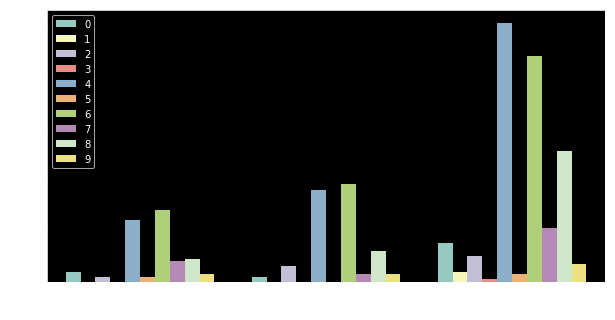

In [48]:
f, ax = plt.subplots(figsize=(10,5)) 
sns.countplot(x='City', hue="Cluster Labels", data=neighborhood_merged)
plt.legend(loc=2)
plt.show()

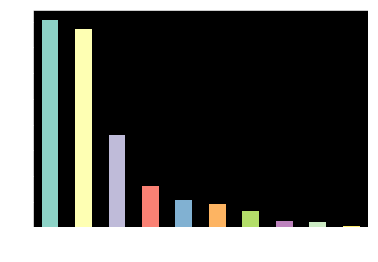

In [49]:
df_cluster_order = neighborhood_merged.groupby('Cluster Labels')['City'].count().sort_values(ascending=False)


figure = plt.figure()
ax = df_cluster_order.plot(kind='bar')

The most common clusters there is to find are 4, 6 8 and 7.

### Let's retrieve NYC, Toronto and Paris coordinates to create their map and visualize the corresponding clusters

In [50]:
address = {'Toronto':'Toronto, Ontario','Paris':'Paris, France', 'NYC':'New York City, NY'}
geolocator = Nominatim()
city_coordinates={}

for x,y in zip(address.keys(),address.values()):
    location = geolocator.geocode(x)
    lat = location.latitude
    lon = location.longitude
    city_coordinates[x] = (lat,lon)

city_coordinates

{'Toronto': (43.653963, -79.387207),
 'Paris': (48.8566101, 2.3514992),
 'NYC': (40.7308619, -73.9871558)}

In [51]:
for city in city_coordinates.keys():
    dfname = str(city)+'_merged'
    print(dfname)
    dfname = neighborhood_merged[neighborhood_merged['City'] == city]
    print(dfname.shape)
    
dfname.head()

Toronto_merged
(100, 25)
Paris_merged
(80, 25)
NYC_merged
(301, 25)


,City,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,...,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
183,NYC,Wakefield,40.894705,-73.847201,8,Pharmacy,Sandwich Place,Food Truck,Donut Shop,Ice Cream Shop,...,Empanada Restaurant,English Restaurant,Eye Doctor,Electronics Store,Egyptian Restaurant,Eastern European Restaurant,EV Charging Station,Exhibit,Factory,Fabric Shop
184,NYC,Co-op City,40.874294,-73.829939,4,Baseball Field,Bus Station,Discount Store,Pharmacy,Mattress Store,...,Film Studio,EV Charging Station,Eastern European Restaurant,Egyptian Restaurant,Flower Shop,Flea Market,Fish Market,Electronics Store,Empanada Restaurant,English Restaurant
185,NYC,Eastchester,40.887556,-73.827806,6,Caribbean Restaurant,Bus Station,Diner,Bowling Alley,Deli / Bodega,...,Pizza Place,Bus Stop,Bakery,Platform,Convenience Store,Fast Food Restaurant,Farm,Exhibit,Empanada Restaurant,English Restaurant
186,NYC,Fieldston,40.895437,-73.905643,4,Bus Station,Plaza,Playground,River,Zoo Exhibit,...,Eye Doctor,Electronics Store,Egyptian Restaurant,Eastern European Restaurant,EV Charging Station,Duty-free Shop,Exhibit,Fabric Shop,Dry Cleaner,Factory
187,NYC,Riverdale,40.890834,-73.912585,7,Park,Bank,Home Service,Plaza,Playground,...,Egyptian Restaurant,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Eastern European Restaurant,EV Charging Station,Exhibit,Zoo Exhibit,Duty-free Shop


### We can now visualize on a folium map the neigborhoods

In [52]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

We will create a function that will print the folium map with the clusters to have a simple visualization of the city clusters

In [53]:
def clustermapping(city,lat,lon,kclusters,city_merged_df,zoom=10):
    # create map
    map_clusters = folium.Map(location=[lat, lon], zoom_start=zoom)

    # set color scheme for the clusters
    x = np.arange(kclusters)
    ys = [i+x+(i*x)**2 for i in range(kclusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    markers_colors = []
    city_merged_df = city_merged_df[city_merged_df['City'] == city]
    for lat, lon, poi, cluster in zip(city_merged_df['Latitude'], city_merged_df['Longitude'], 
        city_merged_df['Neighborhood'], city_merged_df['Cluster Labels']):
        
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(map_clusters)
       
    return map_clusters

In [54]:
cities = list(city_coordinates.keys())
cities

['Toronto', 'Paris', 'NYC']

In [55]:
clustermapping(cities[0],
               city_coordinates[cities[0]][0],
               city_coordinates[cities[0]][1],
               kclusters,
               neighborhood_merged)

In [56]:
clustermapping(cities[1],
               city_coordinates[cities[1]][0],
               city_coordinates[cities[1]][1],
               kclusters,
               neighborhood_merged,
              12)

In [57]:
clustermapping(cities[2],
               city_coordinates[cities[2]][0],
               city_coordinates[cities[2]][1],
               kclusters,
               neighborhood_merged)

Now we have a clear visual to help my friend moving

# 4. Results

Now that we have the dataframe with all clustered numberhood the only thing left to do is create a quick function that will provide us the listing of all matching neighborhoods in the other cities

In [75]:
def relocation_finder(neighborhood='Wakefield'):
    #Let's get the data from the neighborhood prompted
    df_temp = neighborhood_merged[neighborhood_merged['Neighborhood']== neighborhood]
    origin_city = df_temp['City'].values[0]
    target_cluster = df_temp['Cluster Labels'].values[0]
    print('The current city is {} and similar neigborhoods are from cluster {}'
          .format(origin_city,target_cluster))
    print('Here below the similar neighborhoods to yours :')
    #let's create the resulting dataframe with similar neighborhood within the other cities
    df_resulting = neighborhood_merged[neighborhood_merged['Cluster Labels']==target_cluster]
    df_resulting = df_resulting[df_resulting['City']!=origin_city]
    return df_resulting
    

In [74]:
# Now we can prompt for the neighborhood we are currently living and find out about
# which neigborhood in both other cities would be similar to ours based on the clusterization

relocation_finder('Wakefield').head()

The current city is NYC and similar neigborhoods are from cluster 8
Here below the similar neighborhoods to yours


,City,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,...,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
6,Paris,Faubourg-Montmartre,48.873935,2.343253,8,French Restaurant,Hotel,Wine Bar,Burger Joint,Thai Restaurant,...,Bistro,Creperie,Vegetarian / Vegan Restaurant,Indian Restaurant,Cocktail Bar,Eastern European Restaurant,Empanada Restaurant,Bar,Gourmet Shop,Tea Room
12,Paris,St-Germain-l'Auxerrois,48.860650,2.334910,8,French Restaurant,Café,Hotel,Plaza,Coffee Shop,...,Japanese Restaurant,Tea Room,Nightclub,Bookstore,Breakfast Spot,Boutique,Fountain,Bistro,Boat or Ferry,Cupcake Shop
13,Paris,Porte-Saint-Martin,48.871245,2.361504,8,French Restaurant,Coffee Shop,Bar,Hotel,Theater,...,Breakfast Spot,Italian Restaurant,Restaurant,Korean Restaurant,Asian Restaurant,Cocktail Bar,Cambodian Restaurant,Indian Restaurant,Wine Bar,Burger Joint
21,Paris,Parc-de-Montsouris,48.823453,2.337070,8,Italian Restaurant,Theater,Restaurant,Diner,Plaza,...,Chinese Restaurant,Hotel,Japanese Restaurant,Doner Restaurant,Gym,Park,Bus Stop,Electronics Store,Egyptian Restaurant,Empanada Restaurant
33,Paris,Saint-Vincent-de-Paul,48.880735,2.357471,8,French Restaurant,Indian Restaurant,Hotel,Wine Shop,African Restaurant,...,Theater,Bistro,Supermarket,Grocery Store,Sports Bar,Breton Restaurant,Food & Drink Shop,Exhibit,Egyptian Restaurant,Electronics Store


# 5. Discussion

### Limits and improvement of our model
Here we are solely clustering our neighborhoods on the venues that are present in it.
It would certainly be useful to add further data to thise clustering analysis such as :
- Socio economics data (i.e. mean income per capita)
- Number and rating of schools, hospitals (useful when you have children)

The distance to work is critical as well in having a good standard of living.
When trying to analyse where to relocate one should be prompted for its potential place of work (if any) to find a matching neighborhood within the vicinity of work

### Ingesting other cities
Ingest other Capital city data would as well be required for this product to be of any value (there might be people that are relocating in other areas that just NYC, Paris and Toronto :) )

# 6. Conclusion

To conclude this report. 
As it is, this model would not be extremely useful to provide pieces of advice to someone relocating from a city to another.

By includin the above model improvement propositions we would certainly achieve more relevant insights and results.

Thanks for reading me this far !
Hope you enjoyed my way of using what I've learned :)

cheers